## Deploy PPE Detector for Employee Safety from AWS Marketplace 

The PPE Detector for Employee Safety is a real-time computer vision model for identifying PPE non-compliance in working environments. The solution is a tool to ensure worker safety on building sites, fabrication lines, laboratories, steel, oil & gas enterprises, and other industrial environments where safety rules should be strictly followed. The solution is trained on the dataset manually selected and annotated by the VITechLab team. It detects the absence of any of the following objects on a person: Coat, Glasses, Glove, Mask, Helmet. It works with live streams from CCTV cameras.

We also have a ready to use software, PPE Monitoring Platform: https://aws.amazon.com/marketplace/pp/B08BT5CV2F

We provide free support during the trial period! After you've succeeded with the subscription, reach out at support@vitechlab.com


This sample notebook shows you how to deploy [PPE Detector for Employee Safety](https://aws.amazon.com/marketplace/pp/prodview-amn6amvx67dxc) using Amazon SageMaker.


#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to [PPE Detector for Employee Safety](https://aws.amazon.com/marketplace/pp/prodview-amn6amvx67dxc). If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [PPE Detector for Employee Safety](https://aws.amazon.com/marketplace/pp/prodview-amn6amvx67dxc)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn='<Customer to specify Model package ARN corresponding to their AWS region>'

In [2]:
import base64
import json 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import boto3
from IPython.display import Image, display
from PIL import Image as ImageEdit
from PIL import ImageDraw, ImageFont
import urllib.request
import numpy as np

In [3]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

Couldn't call 'get_role' to get Role ARN from role name SageMakerRunner to get Role path.


'sagemaker-eu-central-1-311359980629'

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name='employee-safety-detector-model'
content_type='image/jpeg'

real_time_inference_instance_type='ml.c5.2xlarge'
batch_transform_inference_instance_type='ml.p3.2xlarge'

#### A. Create an endpoint

In [5]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type)

#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)
predictor = sage.predictor.RealTimePredictor(
    model_name,
    sagemaker_session=sagemaker_session, 
    content_type="image/jpeg"
)

---------------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

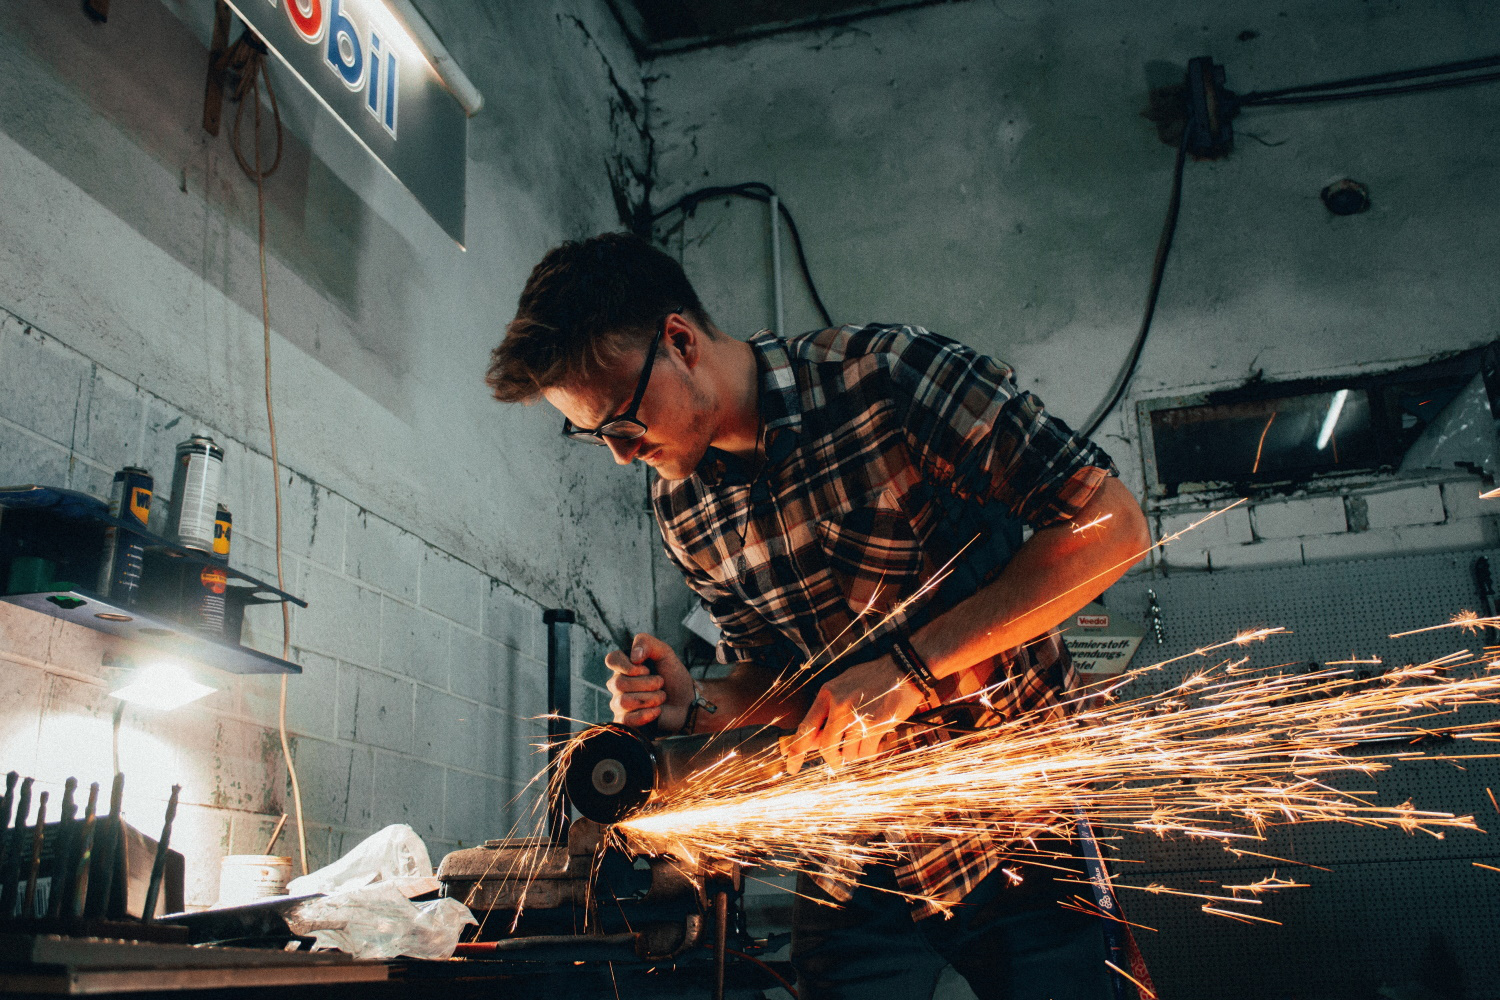

In [6]:
file_name_manufacturing = 'data/input/real-time/example_manufacturing.jpeg'
output_file_name_manufacturing = 'data/output/real-time/example_manufacturing.json'
predict_args_manufacturing = {
        'CustomAttributes': json.dumps(
            {
                'detection-elements': ['no_glasses', 'no_glove', 'no_helmet'],
            }
        )
}
ImageEdit.open(file_name_manufacturing)

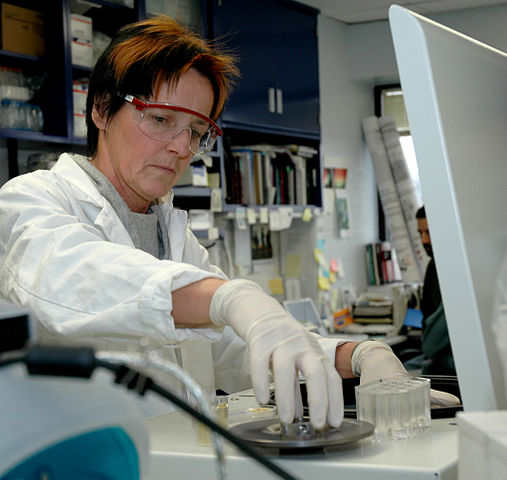

In [7]:
file_name_healthcare = 'data/input/real-time/example_healthcare.jpeg'
output_file_name_healthcare = 'data/output/real-time/example_healthcare.json'
predict_args_healthcare = {
        'CustomAttributes': json.dumps(
            {
                'detection-elements': ['lab_coat', 'lab_no_glasses', 'lab_no_glove', 'lab_no_mask'],
            }
        )
}
ImageEdit.open(file_name_healthcare)

#### C. Real-time inference

In [8]:
def predict(predictor, predict_args, input_name, output_name):
    with open(input_name, 'rb') as image:
        image_bytes = bytearray(image.read())

    result = predictor.predict(image_bytes, predict_args).decode("utf-8")
    result = json.loads(result)

    with open(output_name, 'w') as outfile:
        json.dump(result, outfile)

#### D. Visualize output

In [9]:
def show_detections(file_name, output_file_name):
    text_bg_height = 20
    text_bg_width = 160
    box_color = '#e0e0e0'
    txt_box_color = '#e0e0e0b3'
    default_color = 'black'
    breach_color = '#ff0000'
    
    img = ImageEdit.open(file_name)
    drawing = ImageDraw.Draw(img, 'RGBA')

    with open(output_file_name, "r") as f:
        detections = json.load(f)

    for info in detections:
        xmin, ymin, xmax, ymax = info["box_points"]
        text_bg_height = len(info['classes']) * 20

        if ymin - text_bg_height < 0:
            ymin = ymin + text_bg_height
        
        drawing.rectangle([xmin, ymin, xmax, ymax], outline=box_color, width=2)
        drawing.rectangle([xmin, ymin - text_bg_height, xmin + text_bg_width, ymin], fill=txt_box_color)

        text_offset = -18
        for lbl, conf in info['classes'].items():
            
            # Naming error in the model. Will be fixed in later version
            if lbl == "lab_coat":
                lbl = "lab_no_coat"

            color = breach_color if conf > 50 else default_color

            drawing.text((xmin, ymin + text_offset),
                         f'  {lbl}: {conf:.0f}%',
                         font=ImageFont.load_default(),
                         fill=color)
            text_offset -= 18

    display(img)

#### E. Perform real-time inference

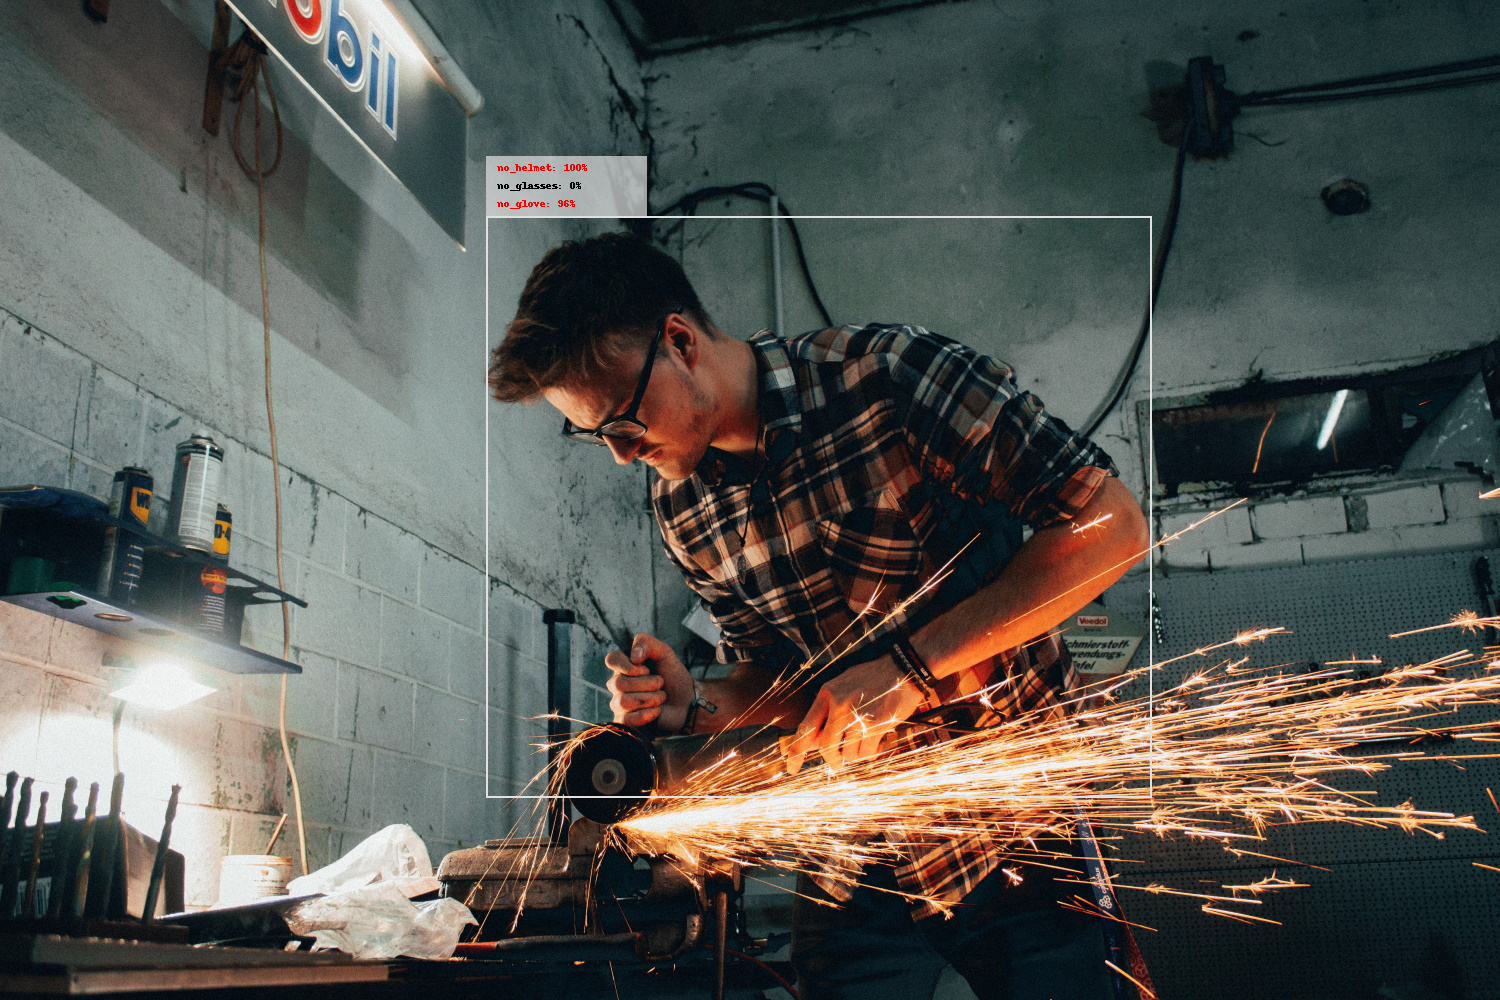

In [10]:
predict(predictor, predict_args_manufacturing, file_name_manufacturing, output_file_name_manufacturing)
show_detections(file_name_manufacturing, output_file_name_manufacturing)

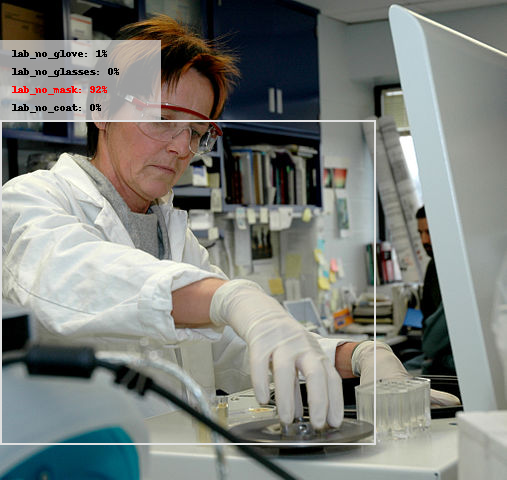

In [11]:
predict(predictor, predict_args_healthcare, file_name_healthcare, output_file_name_healthcare)
show_detections(file_name_healthcare, output_file_name_healthcare)

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [12]:
predictor.delete_endpoint(delete_endpoint_config=True)

### 3. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [13]:
#upload the batch-transform job input files to S3
transform_input_folder = "data/input/batch"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-eu-central-1-311359980629/employee-safety-detector-model


In [14]:
#Run the batch-transform job
transformer = model.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

Using already existing model: vitechlab-ppe-bbb-model-v1-1-398bfa174f-2020-09-10-14-50-17-045


.......................................Starting the inference server with 1 workers.
model_server_timeout is 300
2020/09/10 15:04:35 [crit] 10#10: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
169.254.255.130 - - [10/Sep/2020:15:04:35 +0000] "GET /ping HTTP/1.1" 502 182 "-" "Go-http-client/1.1"
2020/09/10 15:04:35 [crit] 10#10: *3 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 169.254.255.130, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "169.254.255.131:8080"
169.254.255.130 - - [10/Sep/2020:15:04:35 +0000] "GET /ping HTTP/1.1" 502 182 "-" "Go-http-client/1.1"
2020/09/10 15:04:35 [crit] 10#10: *5 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or direct


[VITECH] invocations called
[VITECH] handling image
[VITECH] decoded image of shape (683, 1024, 3)
[VITECH] 4 persons detected
[VITECH] {'name': 'person', 'percentage_probability': 52.775657176971436, 'box_points': [260, 159, 422, 579]}
[VITECH] invocations called
[VITECH] handling image
[VITECH] decoded image of shape (683, 1024, 3)
[VITECH] 4 persons detected
[VITECH] {'name': 'person', 'percentage_probability': 52.775657176971436, 'box_points': [260, 159, 422, 579]}
[VITECH] predicting no_helmet
[VITECH] predicting using head
[VITECH] predicting no_glasses
[VITECH] calling predictor_method
[VITECH] predicting no_glove
[VITECH] predicting using head
[VITECH] predicting lab_coat
[VITECH] predicting using head
[VITECH] predicting lab_no_glasses
[VITECH] predicting using head
[VITECH] predicting lab_no_glove
[VITECH] predicting using head
[VITECH] predicting lab_no_mask
[VITECH] predicting using head
[VITECH] {'name': 'person', 'percentage_probability': 86.97936534881592, 'box_points':

In [17]:
#output is available on following path
transformer.output_path

's3://sagemaker-eu-central-1-311359980629/vitechlab-ppe-bbb-model-v1-1-398bfa174f-2020-09-10-14-58-09-569'

### 4. Clean-up

#### A. Delete the model

In [16]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

